In [1]:
# You can import *ANYTHING* you want here.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error # Requires sklearn 0.24 (December 2020), update with conda/pip if needed.
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from collections import OrderedDict
import pandas as pd

# Assignment 8: Tree methods

In this assignment we'll study tree methods and their capabilities as interpolators and extrapolators, and the importance of understanding your data. We will use a dataset of energy consumption of home appliances for houses in Chievres, Belgium. The data has the following variables:

- date time year-month-day hour:minute:second
- Appliances, energy use in Wh (**Target variable**)energy_extrapolation
- lights, energy use of light fixtures in the house in Wh
- T1, Temperature in kitchen area, in Celsius
- RH_1, Humidity in kitchen area, in %
- T2, Temperature in living room area, in Celsius
- RH_2, Humidity in living room area, in %
- T3, Temperature in laundry room area
- RH_3, Humidity in laundry room area, in %
- T4, Temperature in office room, in Celsius
- RH_4, Humidity in office room, in %
- T5, Temperature in bathroom, in Celsius
- RH_5, Humidity in bathroom, in %
- T6, Temperature outside the building (north side), in Celsius
- RH_6, Humidity outside the building (north side), in %
- T7, Temperature in ironing room , in Celsius
- RH_7, Humidity in ironing room, in %
- T8, Temperature in teenager room 2, in Celsius
- RH_8, Humidity in teenager room 2, in %
- T9, Temperature in parents room, in Celsius
- RH_9, Humidity in parents room, in %
- To, Temperature outside (from Chievres weather station), in Celsius
- Pressure (from Chievres weather station), in mm Hg
- RH_out, Humidity outside (from Chievres weather station), in %
- Wind speed (from Chievres weather station), in m/s
- Visibility (from Chievres weather station), in km
- Tdewpoint (from Chievres weather station), in C degrees

You are given two datasets: energy_appliances_standard.csv and energy_appliances_extrapolation.csv. The first dataset has typical consumption patterns, while the second one has the top 10% highest consumptions and will be used to test the extrapolating capacities of our models.


## Task 1: Random Forests (35/100)

Random Forests are excellent predictors. Usually we only need to tune one parameter: the number of trees in the model. However, how many trees are enough? Follow these steps:

1. Load the training dataset (energy_appliances_standard.csv) and show the descriptive statistics of the variables. (3 pts)

2. Create a train / test partition of the data using 30% of the data for the test set and a ```random_state``` value of 20201107(2 pts).

3. Follow [this example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) and train a [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) using ```Appliances``` as the target variable. Test between 50 and 250 trees, plotting the Out-of-Bag (OOB) error after every iteration. Be patient as training can take a while. Written answer: What is the optimal number of trees for your model and why do you think this? (15 pts)

4. Train your final random forest with the number of trees you selected in part 3. Apply this model over your test set and over the extrapolating dataset (from the file ```energy_appliances_extrapolation.csv```), calculating the mean absolute percentual error for each dataset.  Show in a scatterplot the predicted value vs the real value of the target variable for both the test set and the extrapolation set (in the same plot), differentiating both by using different colors for the points. Written answer: How does the random forest model perform on predicting Appliance energy usage in the extrapolation data set? If it performs poorly, why? If it performs well, why? *Hint: look at the scatterplot*. (15 points)

In [2]:
# Data load
# Read from the file we just got.
energy_data = pd.read_csv('energy_appliances_standard.csv')

#Describe
energy_data.describe()


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
count,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,...,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000
mean,68.121229,3.445729,21.688855,40.150264,20.293891,40.469997,22.230926,39.160423,20.860319,38.983631,...,22.050534,43.016242,19.505556,41.552215,7.314032,755.566425,80.249079,3.969812,38.305214,3.762879
std,30.182146,7.552424,1.604312,3.930099,2.171999,4.063088,1.969945,3.219280,2.047586,4.320711,...,1.961083,5.202160,2.010550,4.161873,5.291010,7.339842,14.768037,2.447164,11.957900,4.187098
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,16.306667,29.600000,14.890000,29.166667,-5.000000,729.366667,24.000000,0.000000,1.000000,-6.600000
25%,50.000000,0.000000,20.760000,37.260000,18.790000,37.930000,20.790000,36.826667,19.566667,35.500000,...,20.828889,39.200000,18.066667,38.530000,3.500000,751.000000,71.333333,2.000000,29.000000,0.933333
50%,60.000000,0.000000,21.600000,39.533333,19.926667,40.545000,22.100000,38.466667,20.666667,38.363333,...,22.166667,42.440000,19.390000,40.863333,6.850000,756.100000,84.333333,3.500000,40.000000,3.433333
75%,80.000000,0.000000,22.600000,42.863333,21.463333,43.326667,23.290000,41.530000,22.100000,42.066667,...,23.390000,46.590000,20.600000,44.290000,10.333333,760.950000,91.845238,5.333333,40.000000,6.550000
max,190.000000,50.000000,26.200000,59.633333,29.856667,56.026667,29.100000,49.656667,26.200000,51.000000,...,27.230000,58.780000,24.500000,53.326667,26.100000,772.283333,100.000000,14.000000,66.000000,15.500000


In [5]:
# Create train / test split
# Split into train and test, fixing seed.
energy_train_noWoE, energy_test_noWoE = train_test_split(energy_data.iloc[:, 0:], # Data 
                                                             test_size = 0.3,           # Size of test
                                                             random_state = 20201107)   # Seed

X = energy_train_noWoE
y = energy_train_noWoE.Appliances
RANDOM_STATE = 20201107

In [71]:
# Generate a binary classification dataset.

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestRegressor(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestRegressor(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestRegressor(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 50
max_estimators = 250

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))


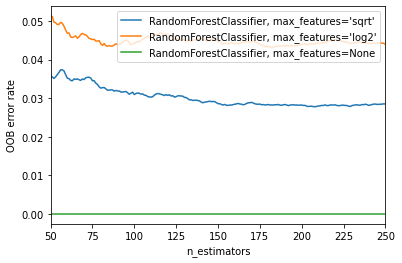

In [72]:
# Plot the OOB error per number of trees
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

**Written answer:** The Optimal Number of Trees is 250 this is because as you increadse the number of trees you reduce your rate of error.


In [94]:
# Final forest
#Define the classifier
energy_rf = RandomForestRegressor(n_estimators=250,random_state=20190305)

# Apply this model over your test set and over the extrapolating dataset (from the file energy_appliances_extrapolation.csv),
# calculating the mean absolute percentual error for each dataset. 

# Train the RF.
energy_rf.fit(energy_train_noWoE.iloc[:,:-1], 
               energy_train_noWoE['Appliances'])

# Apply the model to the test set.
rf_pred_class_test = energy_rf.predict(energy_test_noWoE.iloc[:, :-1])


# Calculate error over test set
# TestError = mean_absolute_percentage_error(energy_train_noWoE['Appliances'], rf_pred_class_test)

# Load the second dataset
energy_data2 = pd.read_csv('energy_appliances_extrapolation.csv')
energy_train_noWoE2, energy_test_noWoE2 = train_test_split(energy_data.iloc[:, 0:], # Data 
                                                             test_size = 0.3,           # Size of test
                                                             random_state = 20201107)   # Seed
energy_rf.fit(energy_train_noWoE2.iloc[:,:-1], 
               energy_train_noWoE2['Appliances'])

rf_pred_class_test2 = energy_rf.predict(energy_test_noWoE2.iloc[:, :-1])

print(len(rf_pred_class_test2))
print(len(energy_train_noWoE2['Appliances']))

# Calculate the error over it
# ExtrapolatedError = mean_absolute_percentage_error(y_true, y_pred)

5321
12414


In [54]:
# Print MAPE over the sets
print(TestError)
print(ExtrapolatedError)

NameError: name 'TestError' is not defined

ValueError: x and y must be the same size

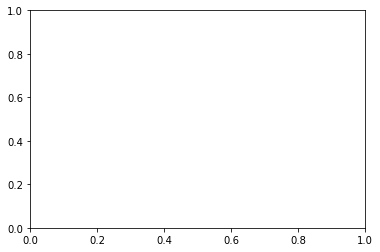

In [43]:
# Make the scatterplot
# Show in a scatterplot the predicted value vs the real value of the target variable for both the test set and 
# the extrapolation set (in the same plot), differentiating both by using different colors for the points

plt.scatter(rf_pred_class_test,y)

**Written answer: **
How does the random forest model perform on predicting Appliance energy usage in the extrapolation data set? If it performs poorly, why? If it performs well, why? 

The model performs poory because it can't extrapolate the linear trend and accurately predict new examples that have a value higher than the training data.


## Task 2: XGBoosting model (40 pts)

Now we'll repeat the process for the XGB model, using an [```XGBRegressor``` object](https://xgboost.readthedocs.io/en/latest/python/python_api.html). The XGBoosting model is much more sensitive to parameter changes though as it allows to tune many different parameters. For this example:

1. Written answer: Why do we say we want to use a small learning rate? Why do we say the number of trees to use depends on each dataset/problem? Why do we want to use a small tree depth? (6 pts)

2. Selecting a 30% validation sample over the training set, tune your parameters using crossvalidation. Use the following ranges:
 - Learning rate: [0.01, 0.1, 0.2].
 - max_depth: 3 to 7.
 - Number of trees: [350, 400, 450, 500]

Leave the other parameters at the values we identified in the lab (except for the objective parameter and those related to classification problems) and use a seed of 20201107. Report the optimal values of your parameters. (20 pts)

3. Repeat part 4 of the previous task, but now for your XGB model trained over the optimal parameter combination and the complete training dataset. Plot the variable importance. Written answer: What are the most important variables? Can the XGB model extrapolate? How does it compare to a random forest? (14 pts)

**Written answer part 1 (2 pts each):**

Why do we say we want to use a small learning rate?

By using a smaller learning rate it will allow the model to learn a more optimal set of weights but can take much longer to train

Why do we say the number of trees to use depends on each dataset/problem?

The number of trees is dependant on each dataset/problem because generally more trees you use the better get the results but the improvement decreases as the number of trees increases and thus will take it longer to train which can be very costly for larger datasets.

Why do we want to use a small tree depth?

We want to use a small tree depth because short trees are very simple and general making binary decisions easy to understand

In [15]:
# Define the XGB model
XGB_Energy = XGBRegressor(max_depth=[3,4,5,6,7],                 # Depth of each tree
                            learning_rate=[0.01, 0.1, 0.2],            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=[350, 400, 450, 500],             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=2,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=1,                  # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=20201107,        # Seed
                            missing=None                  # How are nulls encoded?
                            )

In [16]:
# Define the parameter grid.
param_grid = dict({'n_estimators': [350, 400, 450, 500],
                   'max_depth': [3,4,5,6,7],
                 'learning_rate' : [0.01, 0.1, 0.2]
                  })

In [95]:
# Create reduced validation set.
val_train = energy_train_noWoE.sample(frac = 0.3,               # The fraction to extract
                                       random_state = 20201107    # The seed.
                                       )

In [96]:
# Train grid search. This takes a while! Go grab a coffee.
GridXGB = GridSearchCV(XGB_Energy,        # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = 3,              # Number of cross-validation folds.  
                       scoring = 'roc_auc', # How to rank outputs.
                       n_jobs = -1,         # Parallel jobs. -1 is "all you have"
                       refit = False,       # If refit at the end with the best. We'll do it manually.
                       verbose = 1          # If to show what it is doing.
                      )

GridXGB.fit(val_train.iloc[:, :0], val_train['Appliances'])

Fitting 3 folds for each of 60 candidates, totalling 180 fits


C:\Users\gerri\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0.001,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.01, max_delta_step=None,
                                    max_depth=3, min_child_weight=None,
                                    missing=None, monotone_constraints=None,
                                    n_estimators=350, n_jobs=2,
                                    num_parallel_tree=None,
                                    objective='binary:logistic',
                                    random_state=20201107, reg_alpha=1,
                                    reg_lambda=0, scale_pos_weight=1,
                                    subsample=1, tree_method=None,
  

In [97]:
# Show best params
GridXGB.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 350}

In [45]:
# Train final XGB with optimal parameters
XGB_Energy = XGBRegressor(max_depth=GridXGB.best_params_.get('max_depth'), # Depth of each tree
                            learning_rate=GridXGB.best_params_.get('learning_rate'), # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=GridXGB.best_params_.get('n_estimators'), # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=2,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=1,                  # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=20201107,        # Seed
                            missing=None                  # How are nulls encoded?
                            )
print(XGB_Energy)

XGB_Energy.fit(energy_train_noWoE, 
               energy_train_noWoE['Appliances'])


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=None, max_depth=3,
             min_child_weight=None, missing=None, monotone_constraints=None,
             n_estimators=350, n_jobs=2, num_parallel_tree=None,
             objective='binary:logistic', random_state=20201107, reg_alpha=1,
             reg_lambda=0, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=None, verbosity=1)


XGBoostError: [19:48:02] d:\bld\xgboost-split_1615294821523\work\src\objective\regression_obj.cu:102: label must be in [0,1] for logistic regression

In [98]:
# Variable importance
importances = XGB_Energy.feature_importances_
print(importances)

NotFittedError: need to call fit or load_model beforehand

**Written answer:**

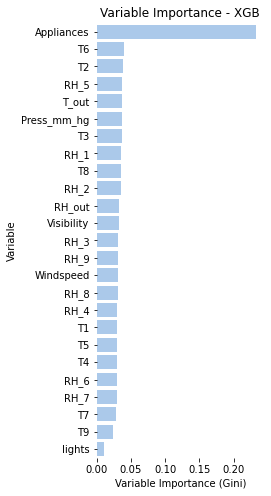

In [102]:
# Make scatterplot
# Plot variable importance
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGB")
sns.set_color_codes("pastel")
sns.barplot(y=[energy_train_noWoE.iloc[:, :-1].columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Gini)")
sns.despine(left=True, bottom=True)

**Written answer: **

What are the most important variables? 

Appliances

Can the XGB model extrapolate?

XGB are unable to extrapolate values beyond the limits of the training data when making predictions


How does it compare to a random forest?

Random Forest is a bagging algorithm and it reduces variance. Where as XGB is reducing variance, and also bias.

## Task 3: Combined model (25 pts)

Now we will finally train a model on the combined data, by joining the extrapolation and the original dataset, and study the performance over the original test set, the new test set and the combined result. For this we will only use the Random Forest model. Use a seed of 20201107 for all functions that accept one.

1. Create a train / test split set over the extrapolation data, leaving approximately 30% of the data for testing purposes. Combine this train test with the original train set (let's call this the combined train set). (5 pts)
2. Train a Random Forest model over the **combined** train data. Discuss how many trees you used and why. (15 pts)
3. Plot the variable importance and compare it versus the XGB in task 1. Now that you more data, does the importance change? (5 pts)
3. Report the test set performance of your new model over the original test set, the test set you took over the extrapolation dataset and the combined test set. Plot the scatterplot of the both datasets as before in the same plot, differentiating the dataset by using colours. (10 pts)

In [64]:
# Create the new train and test set.
energy_data2 = pd.read_csv('energy_appliances_extrapolation.csv')
energy_train_noWoE2, energy_test_noWoE2 = train_test_split(energy_data2.iloc[:, 0:], # Data 
                                                             test_size = 0.3,           # Size of test
                                                             random_state = 20201107)   # Seed

energy_train_noWoE3 = pd.concat([energy_train_noWoE2,energy_train_noWoE])

In [87]:
# Obtain the new random forest (tune the trees)
energy_rf.fit(energy_train_noWoE3.iloc[:,:-1], 
               energy_train_noWoE3['Appliances'])


RandomForestRegressor(n_estimators=250, random_state=20190305)

I used the max amount of trees 250 as it will provide better results

[0.23256362 0.01094707 0.03014076 0.03562594 0.03808642 0.03499622
 0.03657935 0.03188335 0.02997547 0.03040019 0.03001392 0.0377552
 0.03992402 0.02997361 0.02879361 0.02987146 0.03529347 0.03060506
 0.02377523 0.03138812 0.03767062 0.03766982 0.032739   0.03100618
 0.03232229]
[9.98878800e-01 5.54397135e-04 1.52951339e-05 1.17658972e-05
 6.54244482e-06 2.97866384e-05 1.20066585e-05 6.09305532e-06
 2.37136802e-05 2.57175955e-06 2.37143022e-06 1.23231484e-04
 9.00087557e-05 1.44001524e-05 2.35121061e-06 2.43364386e-05
 9.26603775e-06 4.19042081e-06 2.79681736e-06 1.31567387e-05
 4.41514956e-05 3.90716030e-05 3.70464588e-05 1.92714402e-05
 3.33772369e-05]


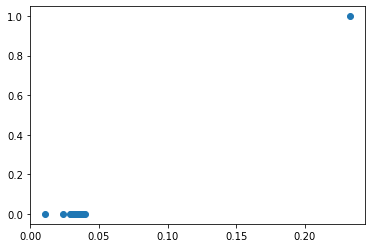

In [90]:
# Variable importance
importances2 = energy_rf.feature_importances_
print(importances)
print(importances2)
plt.scatter(importances, importances2)

**Written answer: **

Now that you more data, does the importance change?

In [ ]:
# Print MAPE over the test sets
TestSetsError = mean_absolute_percentage_error(y_true, y_pred)

In [ ]:
# Scatterplot
plt.scatter(x,y)

**Written answer:**

What happens now? What can you say about the new model?
